In [1]:
import sys
root_dir_abspath = '/home/adnen.boumessouer/LEGO-Anomaly-Detection'

In [2]:
sys.path.insert(0, root_dir_abspath)

In [3]:
import os
from pathlib import Path

import tensorflow as tf
# import skimage
from skimage.util import img_as_ubyte

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import argparse
import time

from processing.preprocessing import Preprocessor
from processing.preprocessing import get_preprocessing_function
from processing import utils
from processing import postprocessing

from processing.postprocessing import calculate_resmaps

In [4]:
import importlib
importlib.reload(postprocessing)

<module 'processing.postprocessing' from '/home/adnen.boumessouer/LEGO-Anomaly-Detection/processing/postprocessing.py'>

# Load CAE

In [5]:
# model_path ="saved_models/LEGO_light/SV/baselineCAE/mssim/21-09-2020_10-02-21/baselineCAE_b8_e181.hdf5" # keep
# model_path = "saved_models/LEGO_light/SV/inceptionCAE/mssim/28-09-2020_09-32-55/inceptionCAE_b8_e293.hdf5"
model_path = "saved_models/LEGO_light/SV/inceptionCAE/mssim/20-09-2020_15-40-36/inceptionCAE_b8_e105.hdf5"

In [6]:
# load model and info
model, info, _ = utils.load_model_HDF5(model_path)

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


In [7]:
# set parameters
input_directory = info["data"]["input_directory"]
architecture = info["model"]["architecture"]
loss = info["model"]["loss"]
rescale = info["preprocessing"]["rescale"]
shape = info["preprocessing"]["shape"]
color_mode = info["preprocessing"]["color_mode"]
vmin = info["preprocessing"]["vmin"]
vmax = info["preprocessing"]["vmax"]
nb_validation_images = info["data"]["nb_validation_images"]

In [8]:
# get the correct preprocessing function
preprocessing_function = info["preprocessing"]["preprocessing"]

In [9]:
info

{'data': {'input_directory': 'LEGO_light/SV',
  'nb_training_images': 260,
  'nb_validation_images': 36,
  'validation_split': 0.1},
 'model': {'architecture': 'inceptionCAE', 'loss': 'mssim'},
 'preprocessing': {'color_mode': 'rgb',
  'rescale': 0.00392156862745098,
  'shape': [256, 256],
  'vmin': 0.0,
  'vmax': 1.0,
  'dynamic_range': 1.0,
  'preprocessing': None},
 'lr_finder': {'lr_base': 0.0001029200284392573,
  'lr_opt': 0.0010144951520487666},
 'training': {'batch_size': 8,
  'epochs_trained': 105,
  'nb_train_images_total': 27300}}

# Validation

## Compute Reconstructions

In [10]:
# initialize preprocessor
preprocessor = Preprocessor(
    input_directory=input_directory,
    rescale=rescale,
    shape=shape,
    color_mode=color_mode,
    preprocessing_function=preprocessing_function,)

In [11]:
# get validation generator
validation_generator = preprocessor.get_val_generator(
    batch_size=nb_validation_images, shuffle=True)

Found 36 images belonging to 1 classes.


In [12]:
# retrieve validation images from generator
imgs_val_input = validation_generator.next()[0]

In [13]:
# display shape
imgs_val_input.shape

(36, 256, 256, 3)

In [14]:
# retrieve validation image names
filenames_val = validation_generator.filenames

In [15]:
# get reconstructed images (i.e predictions) on validation dataset
imgs_val_pred = model.predict(imgs_val_input, verbose=1)

36/36 [==============================] - 7s 192ms/sample


In [16]:
# display shape
imgs_val_pred.shape

(36, 256, 256, 3)

## Plot Original, Reconstructed and Resmap Images (VALIDATION)

In [17]:
tensor_val_abs_gray = postprocessing.TensorImages(
                        imgs_input=imgs_val_input,
                        imgs_pred=imgs_val_pred,
                        vmin=vmin,
                        vmax=vmax,
                        color="grayscale",
                        method="abs",
                        dtype="float64",
                        filenames=filenames_val)

In [18]:
tensor_val_abs_rgb = postprocessing.TensorImages(
                        imgs_input=imgs_val_input,
                        imgs_pred=imgs_val_pred,
                        vmin=vmin,
                        vmax=vmax,
                        color="rgb",
                        method="abs",
                        dtype="float64",
                        filenames=filenames_val)

In [19]:
list_val_good_sv = [
    "good/004.png",
    "good/104.png",
    "good/154.png",
    "good/204.png",
    "good/304.png",
    ]

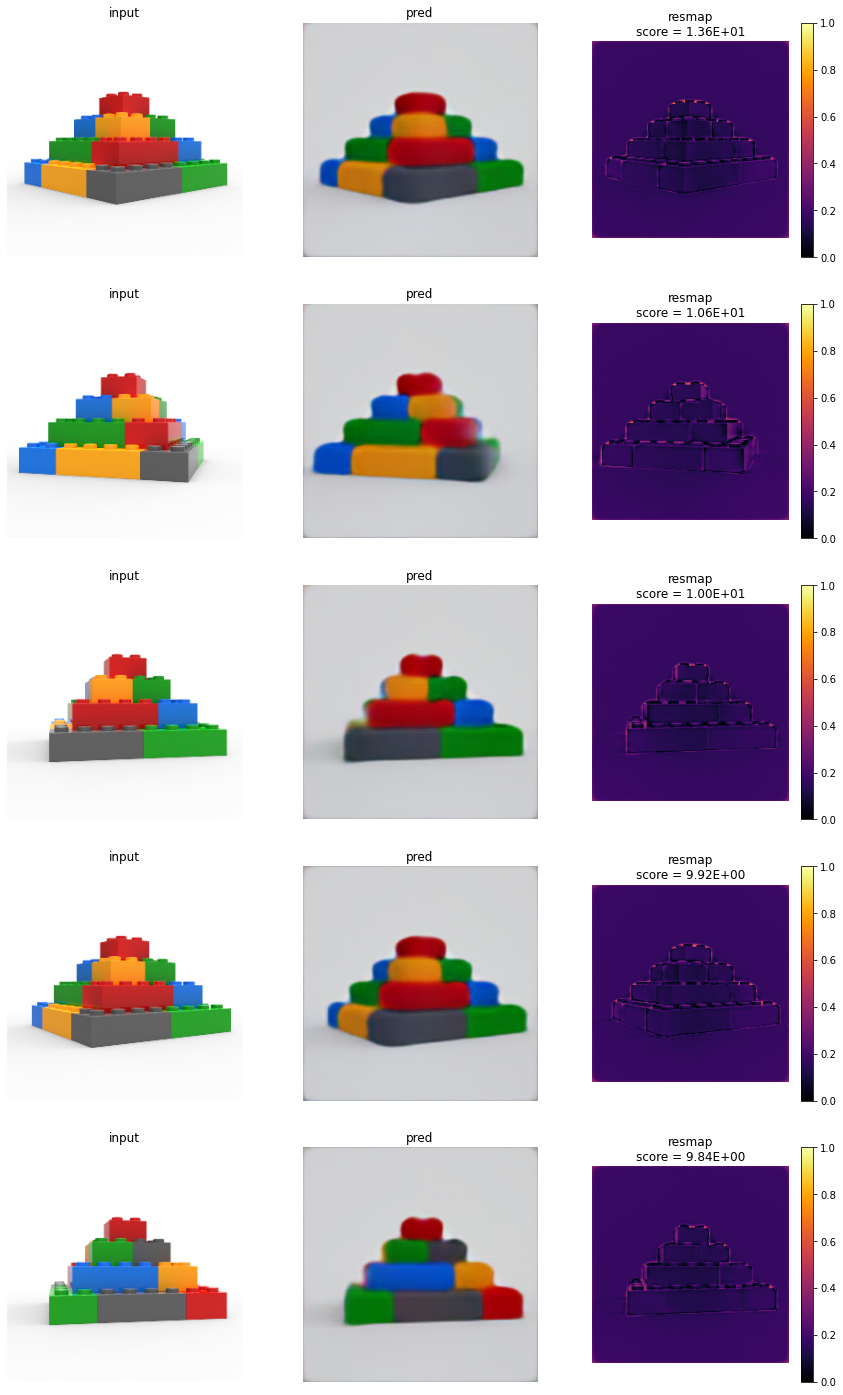

In [20]:
tensor_val_abs_gray.generate_inspection_figure(filenames_plot=list_val_good_sv)

In [55]:
# tensor_val_abs_rgb.generate_inspection_figure(filenames_plot=list_val_good_sv)

# Test Images

In [22]:
threshold = 0.7480000000000006

## Compute Reconstructions

In [23]:
# get test generator
nb_test_images = preprocessor.get_total_number_test_images()
test_generator = preprocessor.get_test_generator(batch_size=nb_test_images, shuffle=False)

Found 497 images belonging to 7 classes.


In [24]:
# retrieve validation images from generator
imgs_test_input = test_generator.next()[0]

In [25]:
# display shape
imgs_test_input.shape

(497, 256, 256, 3)

In [26]:
# retrieve test image names
filenames_test = test_generator.filenames

In [27]:
# get reconstructed images (i.e predictions) on test dataset
imgs_test_pred = model.predict(imgs_test_input, verbose=1)

497/497 [==============================] - 7s 13ms/sample


In [28]:
# display shape
imgs_test_pred.shape

(497, 256, 256, 3)

## Plot Original, Reconstructed and Resmap Images (TEST)

In [29]:
tensor_test_abs_gray = postprocessing.TensorImages(
                            imgs_input=imgs_test_input,
                            imgs_pred=imgs_test_pred,
                            vmin=vmin,
                            vmax=vmax,
                            color="grayscale",
                            method="abs",
                            dtype="float64",
                            filenames=filenames_test)

In [30]:
# tensor_test_abs_rgb = postprocessing.TensorImages(
#                             imgs_input=imgs_test_input,
#                             imgs_pred=imgs_test_pred,
#                             vmin=vmin,
#                             vmax=vmax,
#                             color="rgb",
#                             method="abs",
#                             dtype="float64",
#                             filenames=filenames_test)

### Anomaly-Free Test Images

In [31]:
list_test_good_sv = [
    "good/010.png",
    "good/055.png",
    "good/080.png",
    "good/120.png",
    "good/240.png",  
]

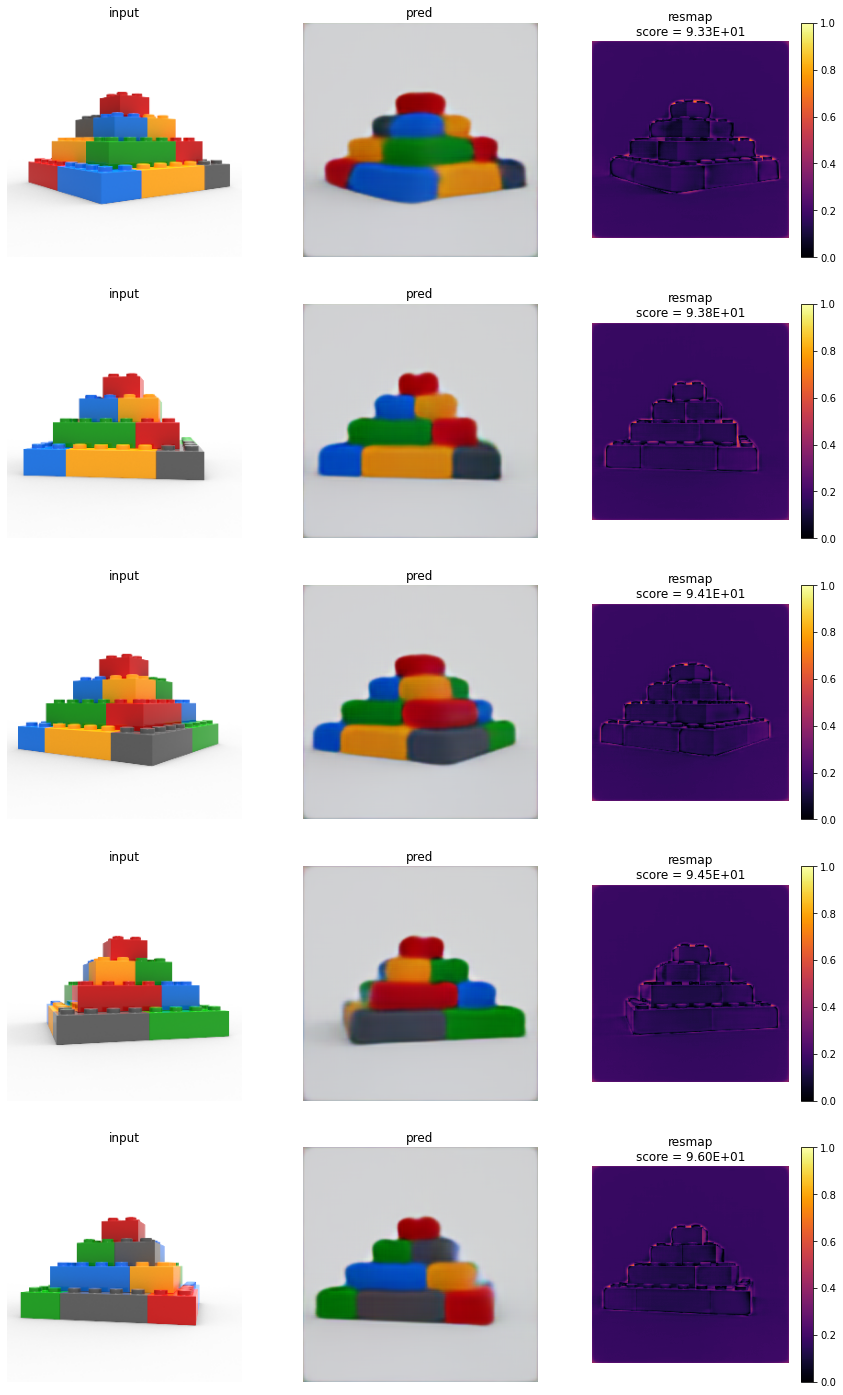

In [32]:
tensor_test_abs_gray.generate_inspection_figure(filenames_plot=list_test_good_sv)

In [56]:
# tensor_test_abs_rgb.generate_inspection_figure(filenames_plot=list_test_good_sv)

### Anomaly type: added Lego-Brick

In [34]:
list_B_added_sv = [
    "B_added_sv/020.png",
    "B_added_sv/040.png",
    "B_added_sv/080.png",
    "B_added_sv/090.png",
    "B_added_sv/120.png",
    "B_added_sv/230.png",
]

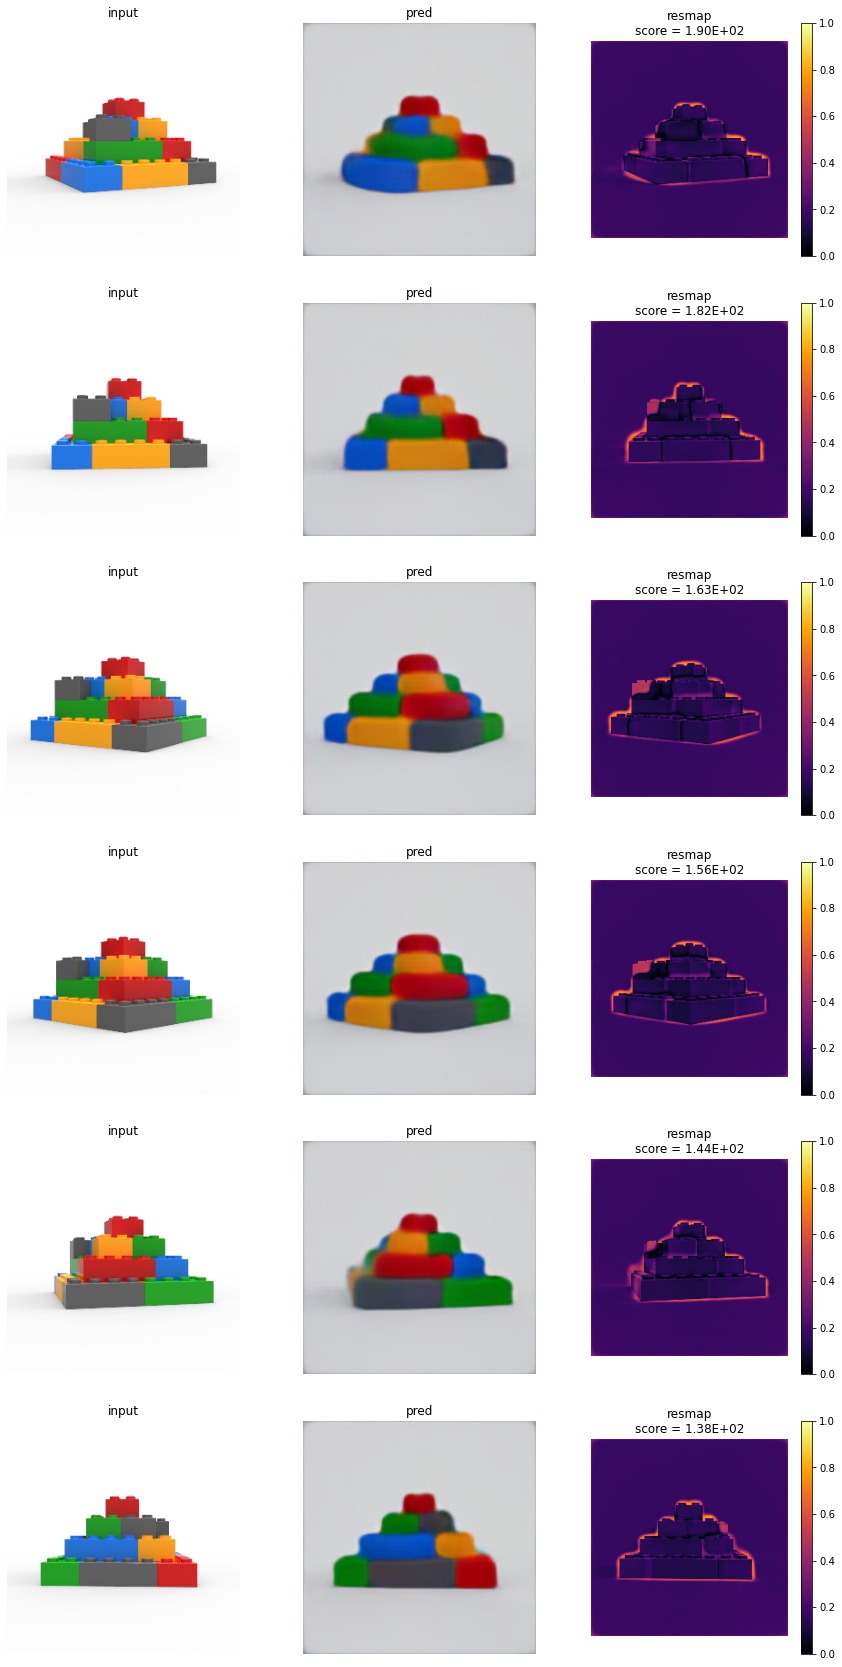

In [35]:
tensor_test_abs_gray.generate_inspection_figure(filenames_plot=list_B_added_sv)

In [57]:
# tensor_test_abs_rgb.generate_inspection_figure(filenames_plot=list_B_added_sv)

### Anomaly type: missing Lego-Brick

In [37]:
list_B_missing_sv = [
    "B_missing_sv/010.png",
    "B_missing_sv/020.png",
    "B_missing_sv/030.png",
    "B_missing_sv/040.png",
    "B_missing_sv/080.png",
    "B_missing_sv/100.png",
    "B_missing_sv/110.png",
    "B_missing_sv/260.png",
    "B_missing_sv/270.png",
    "B_missing_sv/320.png",
]

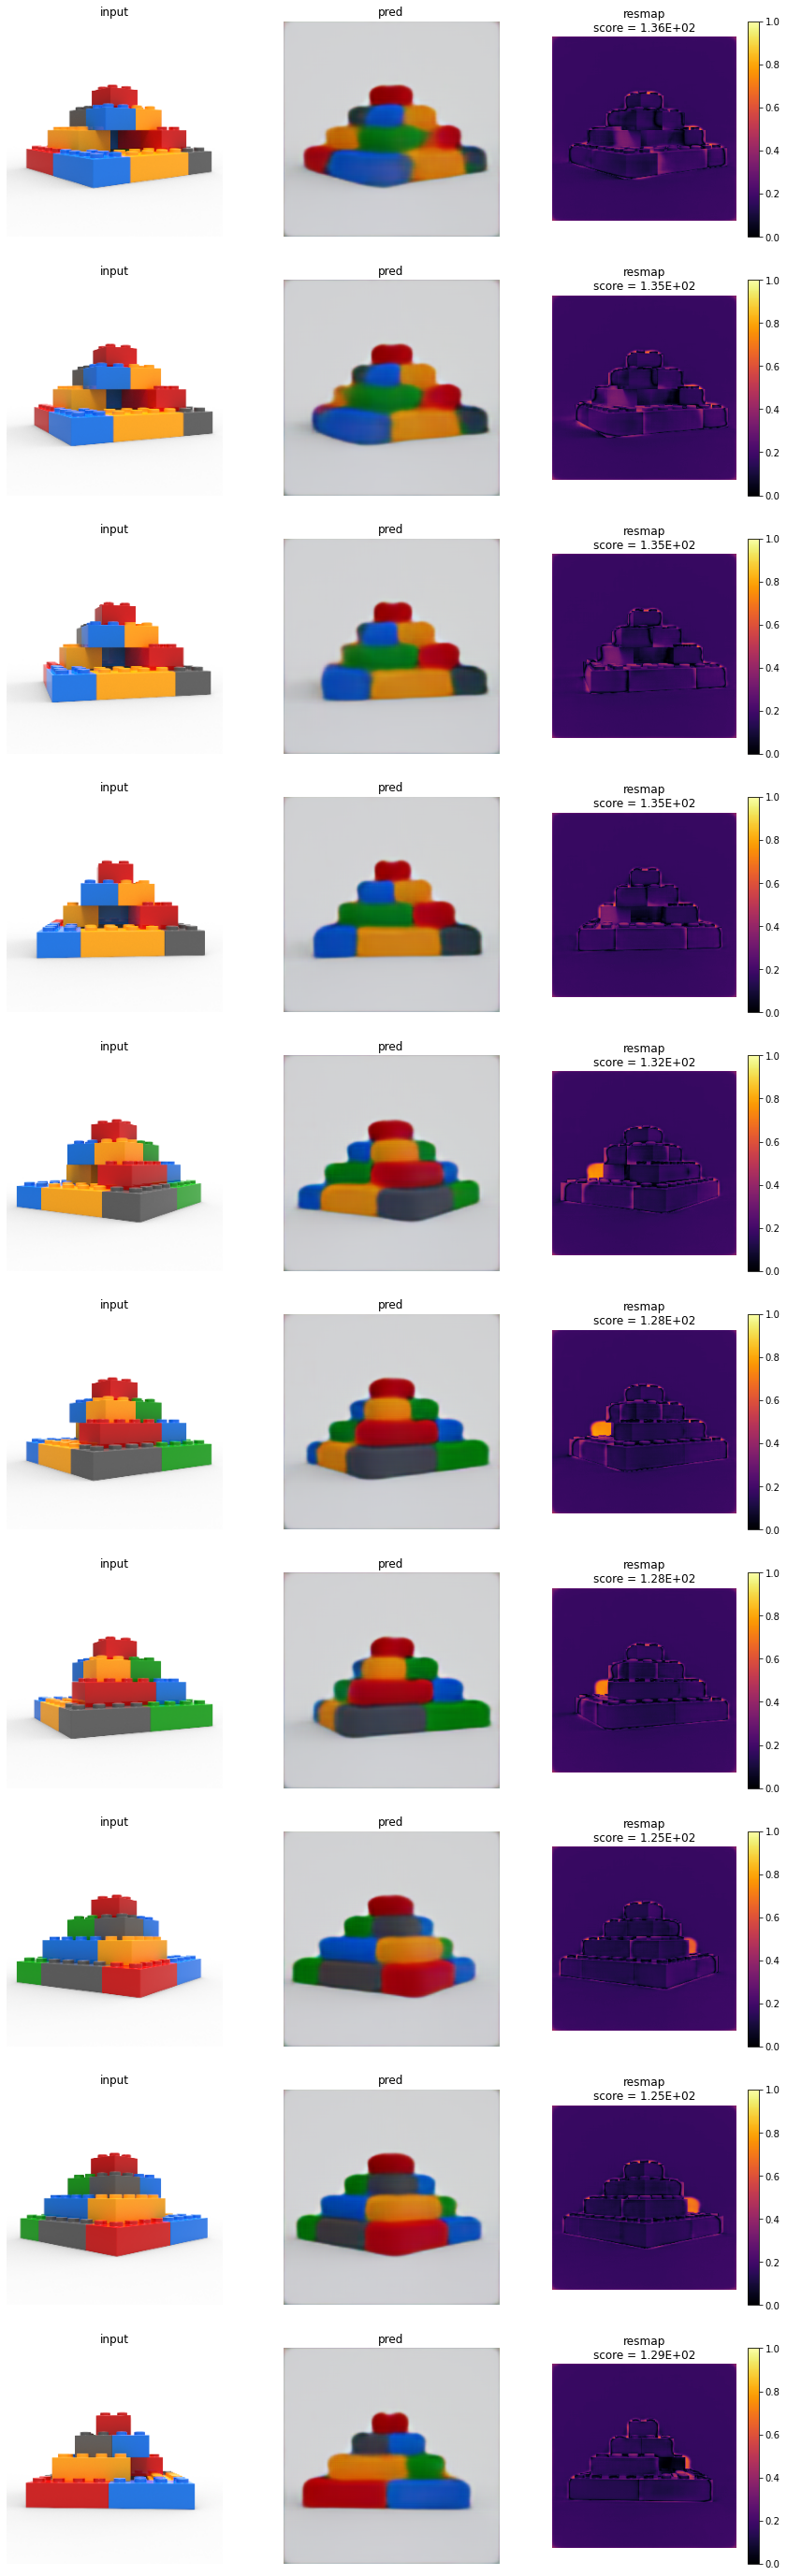

In [38]:
tensor_test_abs_gray.generate_inspection_figure(filenames_plot=list_B_missing_sv)

In [58]:
# tensor_test_abs_rgb.generate_inspection_figure(filenames_plot=list_B_missing_sv)

### Anomaly type: shifted Lego-Brick

In [40]:
list_B_shifted_sv = [
    "B_shifted_sv/010.png",
    "B_shifted_sv/030.png",
    "B_shifted_sv/040.png",
    "B_shifted_sv/100.png",
    "B_shifted_sv/200.png",
    "B_shifted_sv/230.png",
]

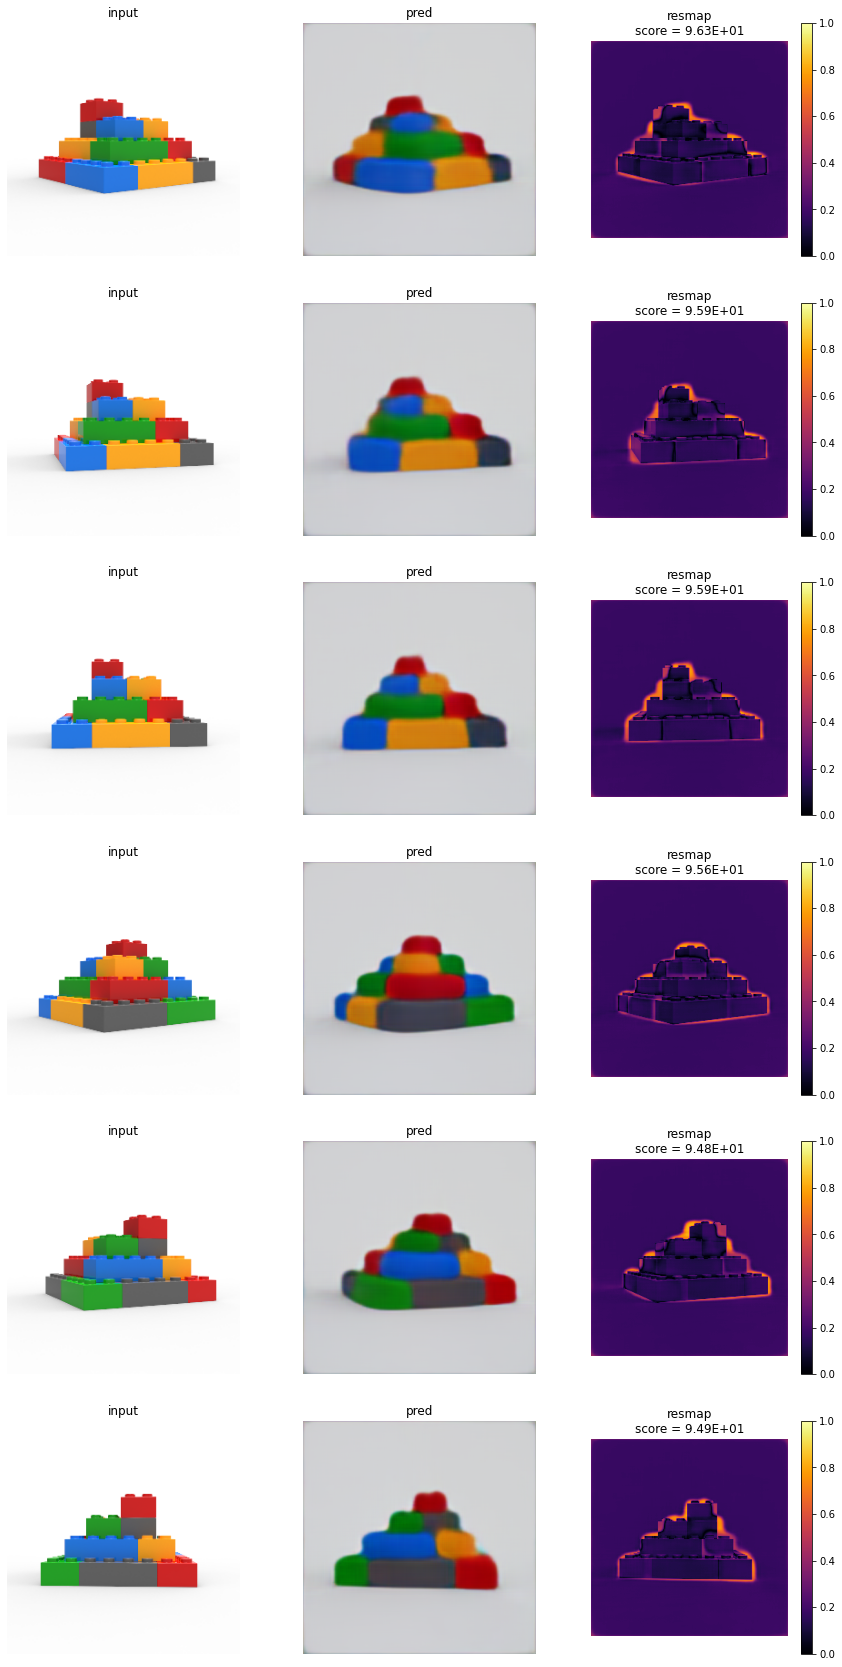

In [41]:
tensor_test_abs_gray.generate_inspection_figure(filenames_plot=list_B_shifted_sv)

In [59]:
# tensor_test_abs_rgb.generate_inspection_figure(filenames_plot=list_B_shifted_sv)

### Anomaly type: false color 1 Lego-Brick

In [43]:
list_C_color_1_sv = [
    "C_color_1_sv/020.png",
    "C_color_1_sv/050.png",
    "C_color_1_sv/110.png",
]

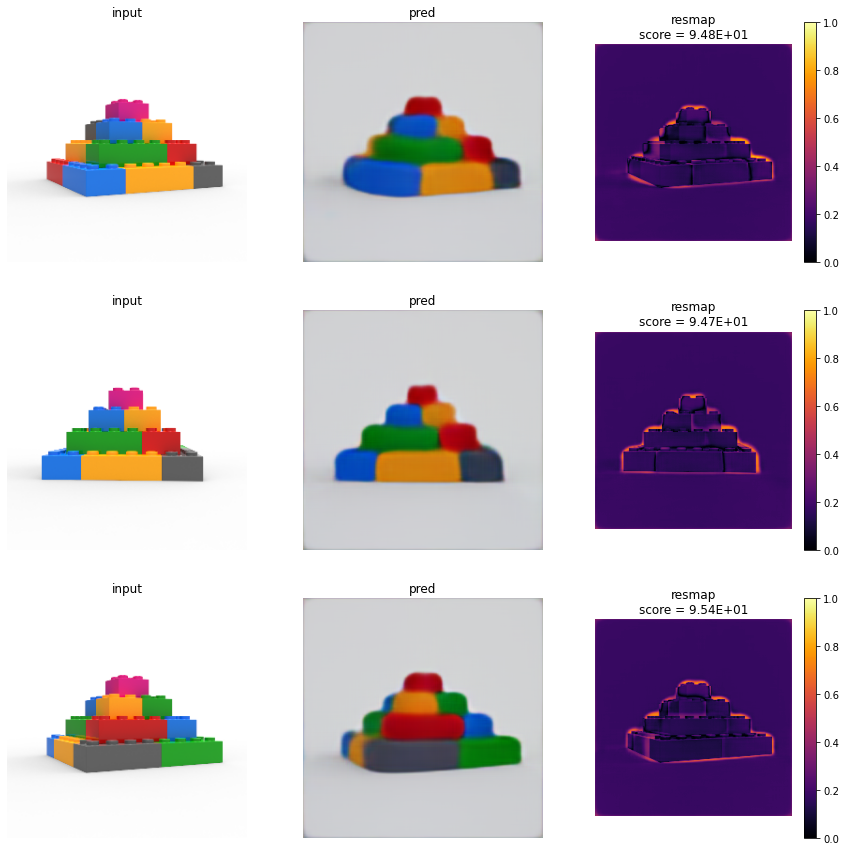

In [44]:
tensor_test_abs_gray.generate_inspection_figure(filenames_plot=list_C_color_1_sv)

In [60]:
# tensor_test_abs_rgb.generate_inspection_figure(filenames_plot=list_C_color_1_sv)

### Anomaly type: false color 2 Lego-Brick

In [46]:
list_C_color_2_sv = [
    "C_color_2_sv/010.png",
    "C_color_2_sv/030.png",
    "C_color_2_sv/080.png",
]

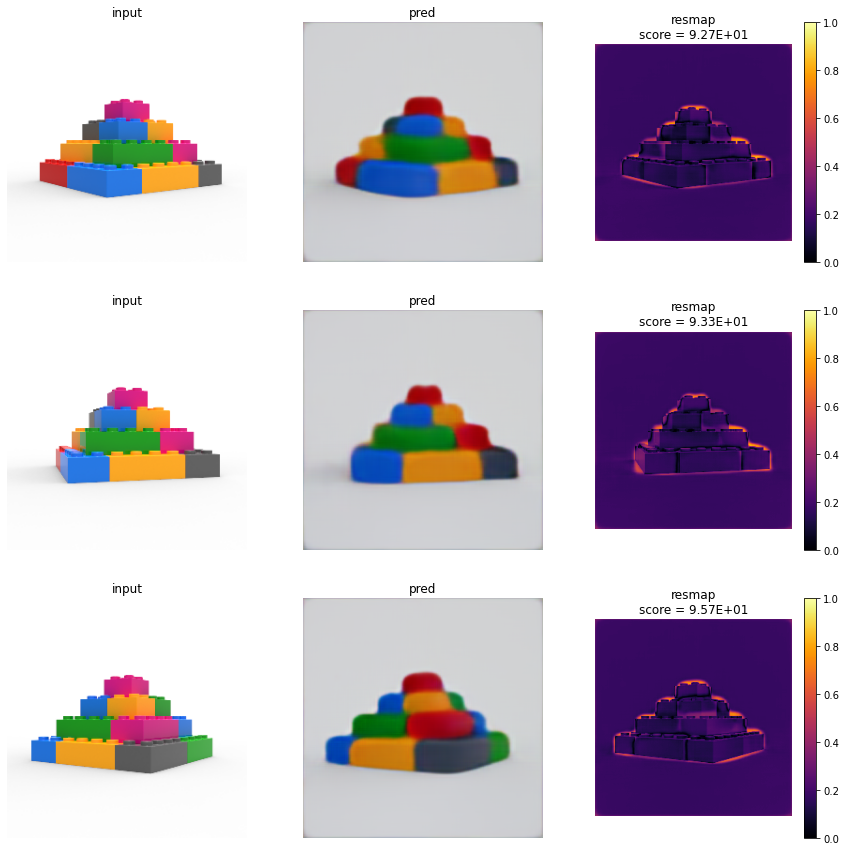

In [47]:
tensor_test_abs_gray.generate_inspection_figure(filenames_plot=list_C_color_2_sv)

In [61]:
# tensor_test_abs_rgb.generate_inspection_figure(filenames_plot=list_C_color_2_sv)

### Anomaly type: false color 3 Lego-Brick

In [49]:
list_C_color_3_sv = [
    "C_color_3_sv/001.png",
    "C_color_3_sv/010.png",
    "C_color_3_sv/180.png",
]

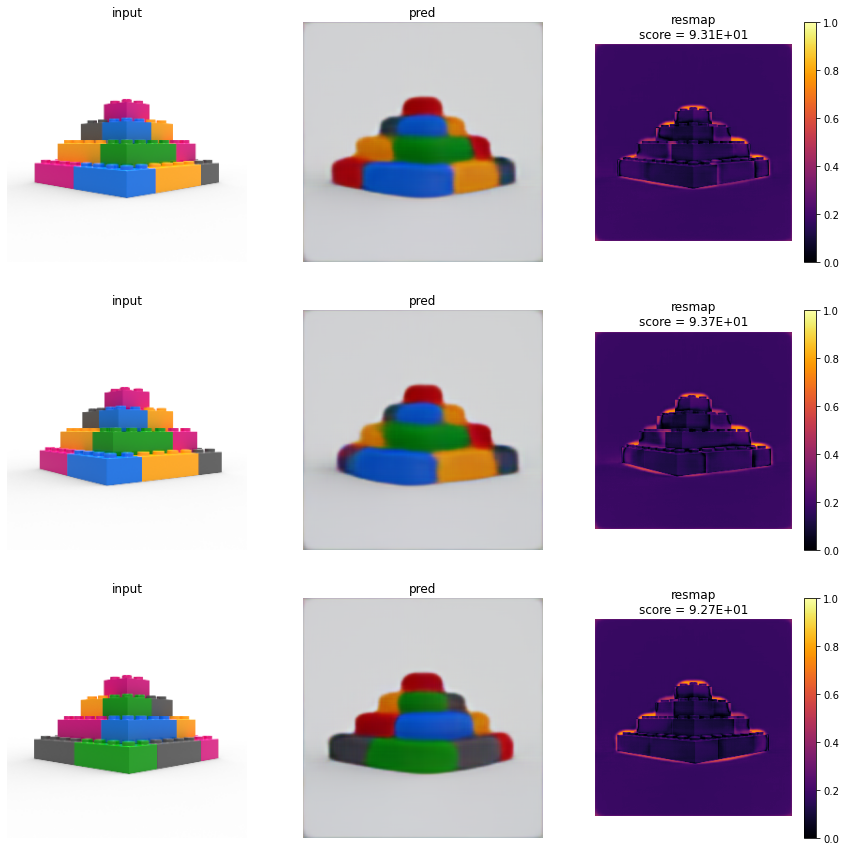

In [50]:
tensor_test_abs_gray.generate_inspection_figure(filenames_plot=list_C_color_3_sv)

In [62]:
# tensor_test_abs_rgb.generate_inspection_figure(filenames_plot=list_C_color_3_sv)

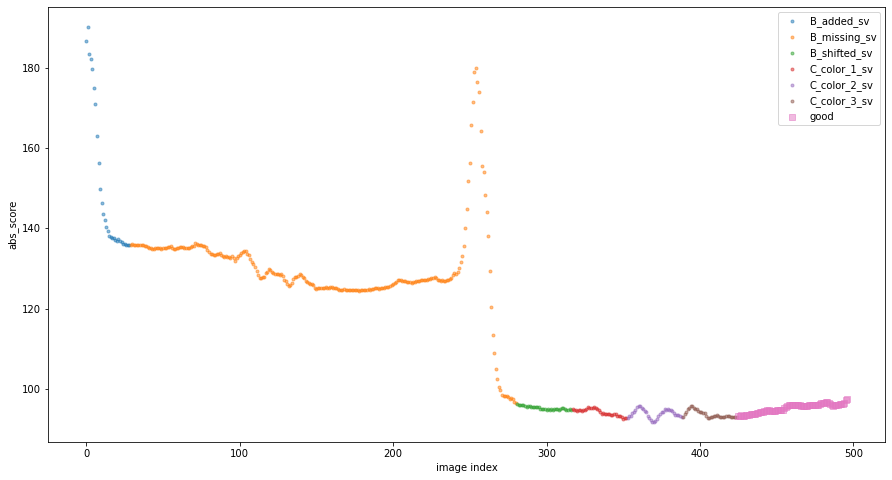

In [52]:
tensor_test_abs_gray.generate_score_scatter_plot(test_generator)

In [63]:
# tensor_test_abs_rgb.generate_score_scatter_plot(test_generator)

In [54]:
# def get_scores_by_category(self, generator):
#     scores_dict = dict()
#     for category in list(generator.class_indices.keys()):
#         indicies_cat = np.nonzero(
#             generator.classes == generator.class_indices[category]
#         )
#         scores_dict[category] = self.scores[indicies_cat]
#     return scores_dict